In [1]:
import os
import polars as pl
import dotenv
from tqdm import tqdm
import plotly.graph_objects as go
FOLDER_PATH = os.getenv("FOLDER_PATH")


dotenv.load_dotenv()
stock = "WBD"

Python-dotenv could not parse statement starting at line 4
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 6
Python-dotenv could not parse statement starting at line 7
Python-dotenv could not parse statement starting at line 8
Python-dotenv could not parse statement starting at line 9
Python-dotenv could not parse statement starting at line 10


In [2]:
parquet_files = [f for f in os.listdir(f"{FOLDER_PATH}{stock}") if f.endswith('.parquet')]
parquet_files.sort()
print(len(parquet_files),"\n",parquet_files)
threshold = len(parquet_files)//10

parquet_files = parquet_files[:threshold]
# Read and concatenate all parquet files
df = pl.concat([
    pl.read_parquet(f"{FOLDER_PATH}{stock}/{file}") 
    for file in parquet_files
])

74 
 ['WBD_2024-07-22.parquet', 'WBD_2024-07-23.parquet', 'WBD_2024-07-24.parquet', 'WBD_2024-07-25.parquet', 'WBD_2024-07-26.parquet', 'WBD_2024-07-29.parquet', 'WBD_2024-07-30.parquet', 'WBD_2024-07-31.parquet', 'WBD_2024-08-01.parquet', 'WBD_2024-08-02.parquet', 'WBD_2024-08-05.parquet', 'WBD_2024-08-06.parquet', 'WBD_2024-08-07.parquet', 'WBD_2024-08-08.parquet', 'WBD_2024-08-09.parquet', 'WBD_2024-08-12.parquet', 'WBD_2024-08-13.parquet', 'WBD_2024-08-14.parquet', 'WBD_2024-08-15.parquet', 'WBD_2024-08-16.parquet', 'WBD_2024-08-19.parquet', 'WBD_2024-08-20.parquet', 'WBD_2024-08-21.parquet', 'WBD_2024-08-22.parquet', 'WBD_2024-08-23.parquet', 'WBD_2024-08-26.parquet', 'WBD_2024-08-27.parquet', 'WBD_2024-08-28.parquet', 'WBD_2024-08-29.parquet', 'WBD_2024-08-30.parquet', 'WBD_2024-09-03.parquet', 'WBD_2024-09-04.parquet', 'WBD_2024-09-05.parquet', 'WBD_2024-09-06.parquet', 'WBD_2024-09-09.parquet', 'WBD_2024-09-10.parquet', 'WBD_2024-09-11.parquet', 'WBD_2024-09-12.parquet', 'WBD_2

In [3]:
def curate_mid_price(df,stock):
    num_entries_by_publisher = df.group_by("publisher_id").len().sort("len", descending=True)
    if len(num_entries_by_publisher) > 1:
            df = df.filter(pl.col("publisher_id") == 41)
        
        
    if stock == "GOOGL":
        df = df.filter(pl.col("ts_event").dt.hour() >= 13)
        df = df.filter(pl.col("ts_event").dt.hour() <= 20)
        
        
    else:
        df = df.filter(
            (
                (pl.col("ts_event").dt.hour() == 9) & (pl.col("ts_event").dt.minute() >= 35) |
                (pl.col("ts_event").dt.hour() > 9) & (pl.col("ts_event").dt.hour() < 16)
            )
        )
    
    # Remove the first row at 9:30
    df = df.with_row_index("index").filter(
        ~((pl.col("ts_event").dt.hour() == 9) & 
          (pl.col("ts_event").dt.minute() == 30) & 
          (pl.col("index") == df.filter(
              (pl.col("ts_event").dt.hour() == 9) & 
              (pl.col("ts_event").dt.minute() == 30)
          ).with_row_index("index").select("index").min())
        )
    ).drop("index")
    mid_price = (df["ask_px_00"] + df["bid_px_00"]) / 2
    
    
    # managing nans or infs, preceding value filling
    mid_price = mid_price.fill_nan(mid_price.shift(1))
    df = df.with_columns(mid_price=mid_price)
    # now we define the mid price with the microprice, barycenter of bid and ask prices by their weights
    
    micro_price = (df["ask_px_00"] * df["bid_sz_00"] + df["bid_px_00"] * df["ask_sz_00"]) / (df["bid_sz_00"] + df["ask_sz_00"])
    df = df.with_columns(mid_price=micro_price)
    # sort by ts_event
    df = df.sort("ts_event")
    return df


In [4]:
df  = curate_mid_price(df,stock)

# average bid ask spread
avg_spread = (df["ask_px_00"] - df["bid_px_00"]).mean()

In [5]:
print(f"Average bid ask spread: {avg_spread}")

Average bid ask spread: 0.01083067877095691


In [6]:
df.head()

ts_event,rtype,publisher_id,instrument_id,action,side,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,ask_px_00,bid_sz_00,ask_sz_00,bid_ct_00,ask_ct_00,bid_px_01,ask_px_01,bid_sz_01,ask_sz_01,bid_ct_01,ask_ct_01,bid_px_02,ask_px_02,bid_sz_02,ask_sz_02,bid_ct_02,ask_ct_02,bid_px_03,ask_px_03,bid_sz_03,ask_sz_03,bid_ct_03,ask_ct_03,bid_px_04,…,ask_sz_04,bid_ct_04,ask_ct_04,bid_px_05,ask_px_05,bid_sz_05,ask_sz_05,bid_ct_05,ask_ct_05,bid_px_06,ask_px_06,bid_sz_06,ask_sz_06,bid_ct_06,ask_ct_06,bid_px_07,ask_px_07,bid_sz_07,ask_sz_07,bid_ct_07,ask_ct_07,bid_px_08,ask_px_08,bid_sz_08,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol,date,ts_recv,mid_price
"datetime[ns, US/Eastern]",u8,u16,u32,str,str,u8,f64,u32,u8,i32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,…,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,f64,f64,u32,u32,u32,u32,str,date,"datetime[ns, UTC]",f64
2024-07-22 09:35:00.001689461 EDT,10,2,17256,"""C""","""B""",1,8.5,1200,130,166251,30418076,8.51,8.52,200,3149,1,7,8.5,8.53,4380,5667,10,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4749,5304,9,8,8.47,…,4400,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.001855712 UTC,8.510597
2024-07-22 09:35:00.001985212 EDT,10,2,17256,"""C""","""B""",1,8.5,1400,130,165477,30418188,8.51,8.52,200,3149,1,7,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4749,5304,9,8,8.47,…,4400,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.002150689 UTC,8.510597
2024-07-22 09:35:00.029098385 EDT,10,2,17256,"""A""","""B""",3,8.48,24,130,165997,30425918,8.51,8.52,200,3149,1,7,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4773,5304,10,8,8.47,…,4400,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.029264382 UTC,8.510597
2024-07-22 09:35:00.217015369 EDT,10,2,17256,"""T""","""N""",0,8.515,13,130,166957,30444216,8.51,8.52,200,3149,1,7,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4773,5304,10,8,8.47,…,4400,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.217182326 UTC,8.510597
2024-07-22 09:35:00.217059151 EDT,10,2,17256,"""A""","""A""",0,8.52,500,130,165580,30444220,8.51,8.52,200,3649,1,8,8.5,8.53,2980,5667,9,12,8.49,8.54,5592,5712,10,8,8.48,8.55,4773,5304,10,8,8.47,…,4400,9,6,8.46,8.57,12888,805,12,3,8.45,8.58,1085,1700,8,5,8.44,8.59,454,302,4,4,8.43,8.6,113,1066,2,6,8.42,8.62,352,110,4,1,"""WBD""",2024-07-22,2024-07-22 13:35:00.217224731 UTC,8.51052


In [7]:
df_cleaned = df[["ts_event","mid_price"]]

In [8]:
df_cleaned = df[["ts_event","mid_price","micro_price"]]

ColumnNotFoundError: "micro_price" not found

Average arrival time

Average time between mid price changes: shape: (1, 1)
┌──────────────┐
│ time_diff_ms │
│ ---          │
│ f64          │
╞══════════════╡
│ 319.653891   │
└──────────────┘


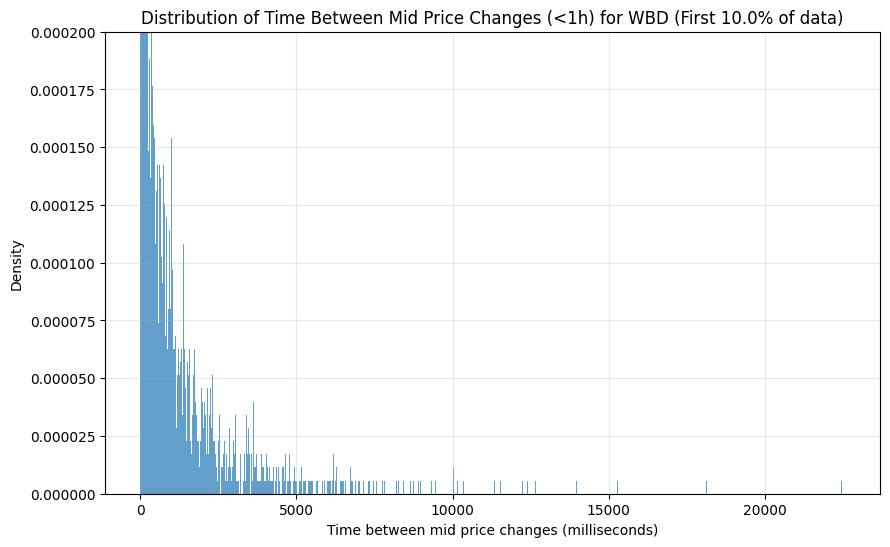

In [9]:
# Compute average time between mid price changes
import numpy as np
import matplotlib.pyplot as plt

# Calculate time differences between mid price changes in nanoseconds and convert to milliseconds
time_diffs = df.with_columns(
    mid_price_change=pl.col("mid_price").diff()
).filter(
    pl.col("mid_price_change") != 0
).select(
    (pl.col("ts_event").diff().cast(pl.Int64) / 1_000_000).alias("time_diff_ms")  # Convert to milliseconds
).drop_nulls()

# Filter out times > 1 hour (3600000 milliseconds) 
time_diffs = time_diffs.filter(pl.col("time_diff_ms") <= 36000)

# Take first alpha fraction of data
alpha = 0.1  # Use first 10% of data
time_diffs_np = time_diffs.to_numpy().flatten()[:int(len(time_diffs) * alpha)]

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(time_diffs_np, bins='auto', density=True, alpha=0.7)

plt.title(f'Distribution of Time Between Mid Price Changes (<1h) for {stock} (First {alpha*100}% of data)')
plt.xlabel('Time between mid price changes (milliseconds)')
plt.ylabel('Density')
plt.ylim(0,0.0002)
print('Average time between mid price changes:', time_diffs.mean())
avg_arrival_time = time_diffs.mean()["time_diff_ms"][0] 
plt.grid(True, alpha=0.3)

In [10]:

# Save plot
os.makedirs(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/", exist_ok=True)
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_arrival_times.png")


<Figure size 640x480 with 0 Axes>

In [11]:
time_scales = [str(int(k*avg_arrival_time))+"us" for k in [1,5,10,30,100,1000,3000,10000,30000,100000,300000,1000000,3000000]]
print(time_scales)

['319us', '1598us', '3196us', '9589us', '31965us', '319653us', '958961us', '3196538us', '9589616us', '31965389us', '95896167us', '319653890us', '958961672us']


In [12]:
time_scales = time_scales

dfs = {}

for scale in time_scales:
    df_temp = df_cleaned.group_by(pl.col("ts_event").dt.truncate(scale)).agg([
        pl.col("mid_price").last().alias("mid_price")
    ])
    
    df_temp = df_temp.sort("ts_event")
    
    df_temp = df_temp.with_columns(
        tick_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").diff()/avg_spread)
        .otherwise(None)
    )
    df_temp = df_temp.with_columns(
        log_variation=pl.when(pl.col("ts_event").dt.date().diff() == 0)
        .then(pl.col("mid_price").log().diff())
        .otherwise(None)
    )
    
    dfs[scale] = df_temp
    
    print(f"\n{scale} sampling:")
    print(df_temp.head())


319us sampling:
shape: (5, 4)
┌────────────────────────────────┬───────────┬────────────────┬───────────────┐
│ ts_event                       ┆ mid_price ┆ tick_variation ┆ log_variation │
│ ---                            ┆ ---       ┆ ---            ┆ ---           │
│ datetime[ns, US/Eastern]       ┆ f64       ┆ f64            ┆ f64           │
╞════════════════════════════════╪═══════════╪════════════════╪═══════════════╡
│ 2024-07-22 09:35:00.001627 EDT ┆ 8.510597  ┆ null           ┆ null          │
│ 2024-07-22 09:35:00.001946 EDT ┆ 8.510597  ┆ 0.0            ┆ 0.0           │
│ 2024-07-22 09:35:00.029061 EDT ┆ 8.510597  ┆ 0.0            ┆ 0.0           │
│ 2024-07-22 09:35:00.216952 EDT ┆ 8.51052   ┆ -0.007163      ┆ -0.000009     │
│ 2024-07-22 09:35:00.217271 EDT ┆ 8.504339  ┆ -0.570623      ┆ -0.000726     │
└────────────────────────────────┴───────────┴────────────────┴───────────────┘

1598us sampling:
shape: (5, 4)
┌────────────────────────────────┬───────────┬───────────

In [48]:
"""
import plotly.graph_objects as go

# Create plots for each time scale
for scale in time_scales:
    df_current = dfs[scale]
    
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x=df_current["ts_event"], y=df_current["mid_price"], name="Mid Price")
    )
    fig.update_layout(
        title=f"{scale} Sampling",
        xaxis_title="Time", 
        yaxis_title="Mid Price"
    )
    fig.show()
"""

'\nimport plotly.graph_objects as go\n\n# Create plots for each time scale\nfor scale in time_scales:\n    df_current = dfs[scale]\n    \n    fig = go.Figure()\n    fig.add_trace(\n        go.Scatter(x=df_current["ts_event"], y=df_current["mid_price"], name="Mid Price")\n    )\n    fig.update_layout(\n        title=f"{scale} Sampling",\n        xaxis_title="Time", \n        yaxis_title="Mid Price"\n    )\n    fig.show()\n'

In [13]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("tick_variation").is_not_null())
        .then((pl.col("tick_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("vol_bachelier").describe())



Bachelier volatility stats for 319us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ vol_bachelier │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 408471.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 64.453071     │
│ std        ┆ 291.737415    │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.537751      │
│ 75%        ┆ 14.921346     │
│ max        ┆ 16108.944499  │
└────────────┴───────────────┘

Bachelier volatility stats for 1598us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ vol_bachelier │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 326592.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 27.338456     │
│ std        ┆ 131.58487     │
│ min        ┆ 0.0           │
│ 25%        ┆ 0.0           │
│ 50%        ┆ 0.37472       │
│ 75%        ┆ 7.464392      │
│ max  

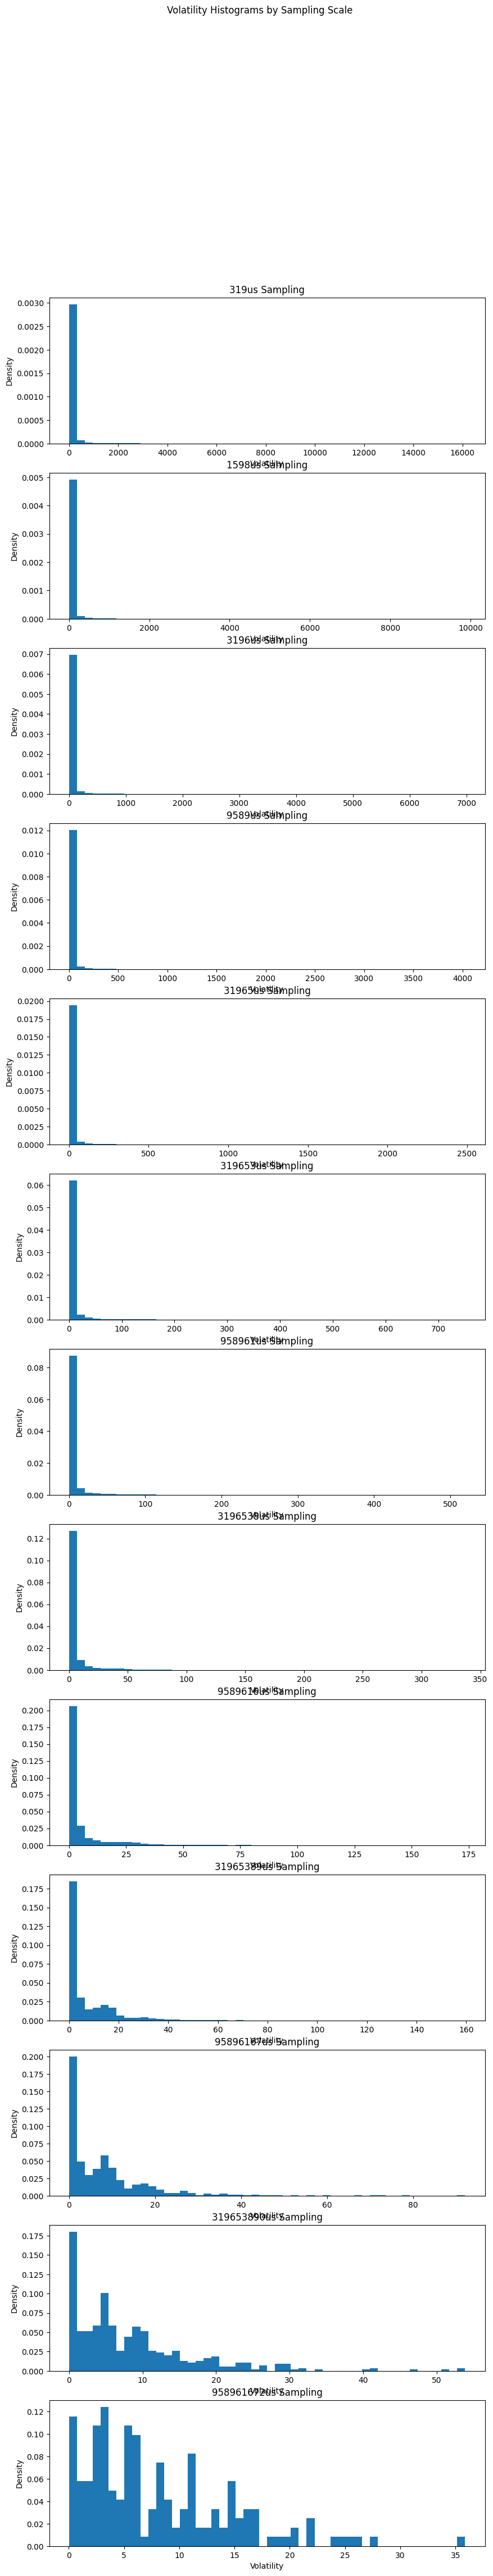

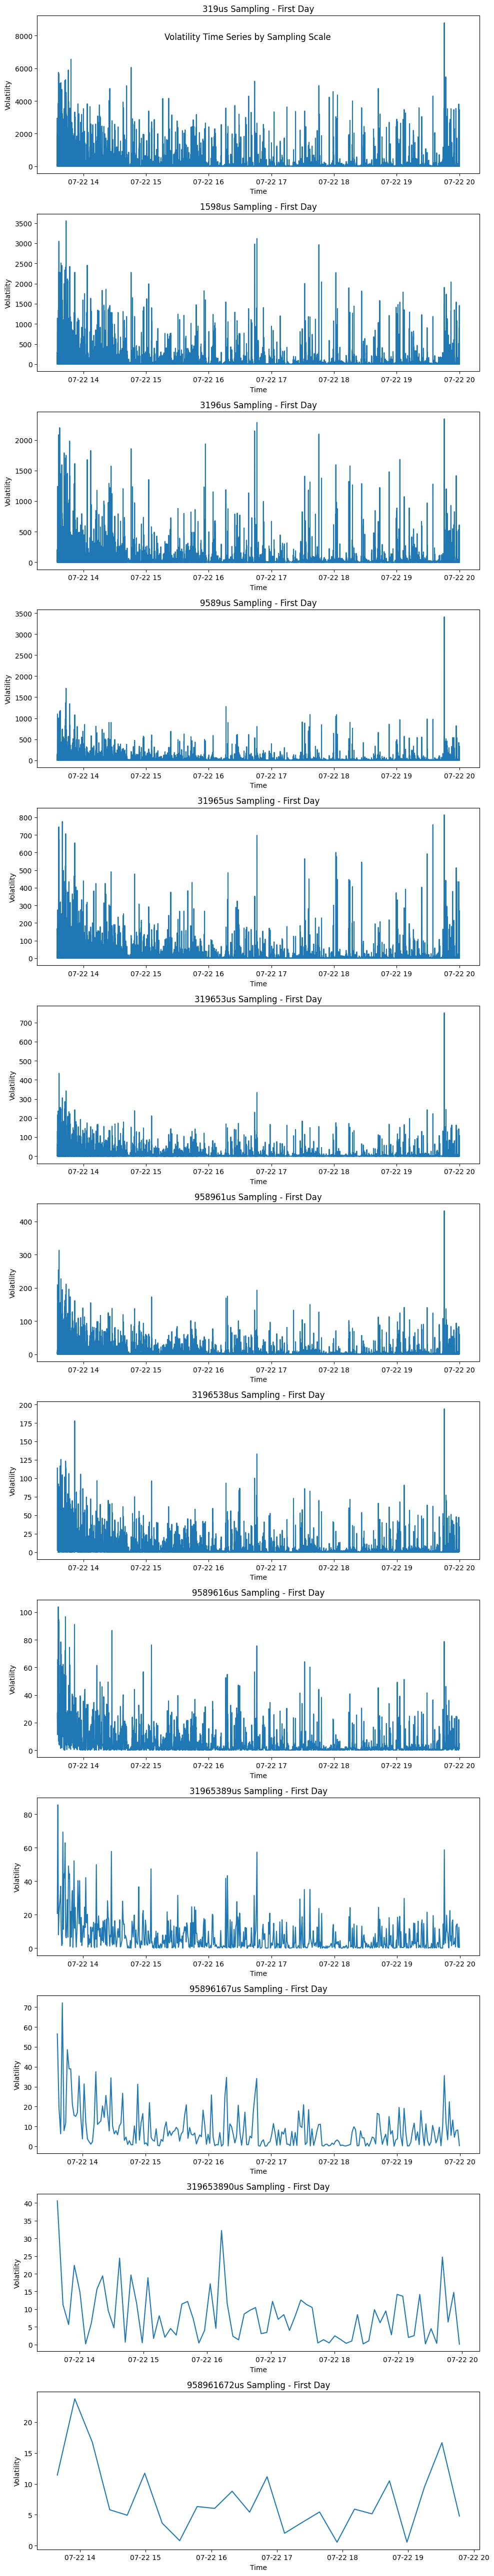

<Figure size 640x480 with 0 Axes>

In [14]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('vol_bachelier').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('vol_bachelier').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")

In [20]:
# Calculate volatility under Bachelier model
# In Bachelier model, log returns are normally distributed with variance = sigma^2 * dt
# So sigma = sqrt(var(log returns) / dt)
for scale in time_scales:
    df_current = dfs[scale]
    
    # Add time difference column in seconds by converting nanoseconds to seconds
    df_current = df_current.with_columns(
        dt=pl.col("ts_event").diff().cast(pl.Int64) / 1e9  # Convert directly to seconds
    )
    
    # Calculate volatility using log variations and time differences, normalized by avg_spread
    df_current = df_current.with_columns(
        vol_bachelier=pl.when(pl.col("log_variation").is_not_null())
        .then((pl.col("log_variation").abs() / pl.col("dt").sqrt()) / avg_spread)
        .otherwise(None)
    )
    
    dfs[scale] = df_current
    
    # Print summary statistics
    print(f"\nBachelier volatility stats for {scale} sampling:")
    print(df_current.select("log_variation").describe())



Bachelier volatility stats for 319us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ log_variation │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 408471.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 1.8689e-7     │
│ std        ┆ 0.000112      │
│ min        ┆ -0.004386     │
│ 25%        ┆ -0.000003     │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.000002      │
│ max        ┆ 0.004315      │
└────────────┴───────────────┘

Bachelier volatility stats for 1598us sampling:
shape: (9, 2)
┌────────────┬───────────────┐
│ statistic  ┆ log_variation │
│ ---        ┆ ---           │
│ str        ┆ f64           │
╞════════════╪═══════════════╡
│ count      ┆ 326592.0      │
│ null_count ┆ 7.0           │
│ mean       ┆ 2.3375e-7     │
│ std        ┆ 0.000128      │
│ min        ┆ -0.004386     │
│ 25%        ┆ -0.000003     │
│ 50%        ┆ 0.0           │
│ 75%        ┆ 0.000002      │
│ max  

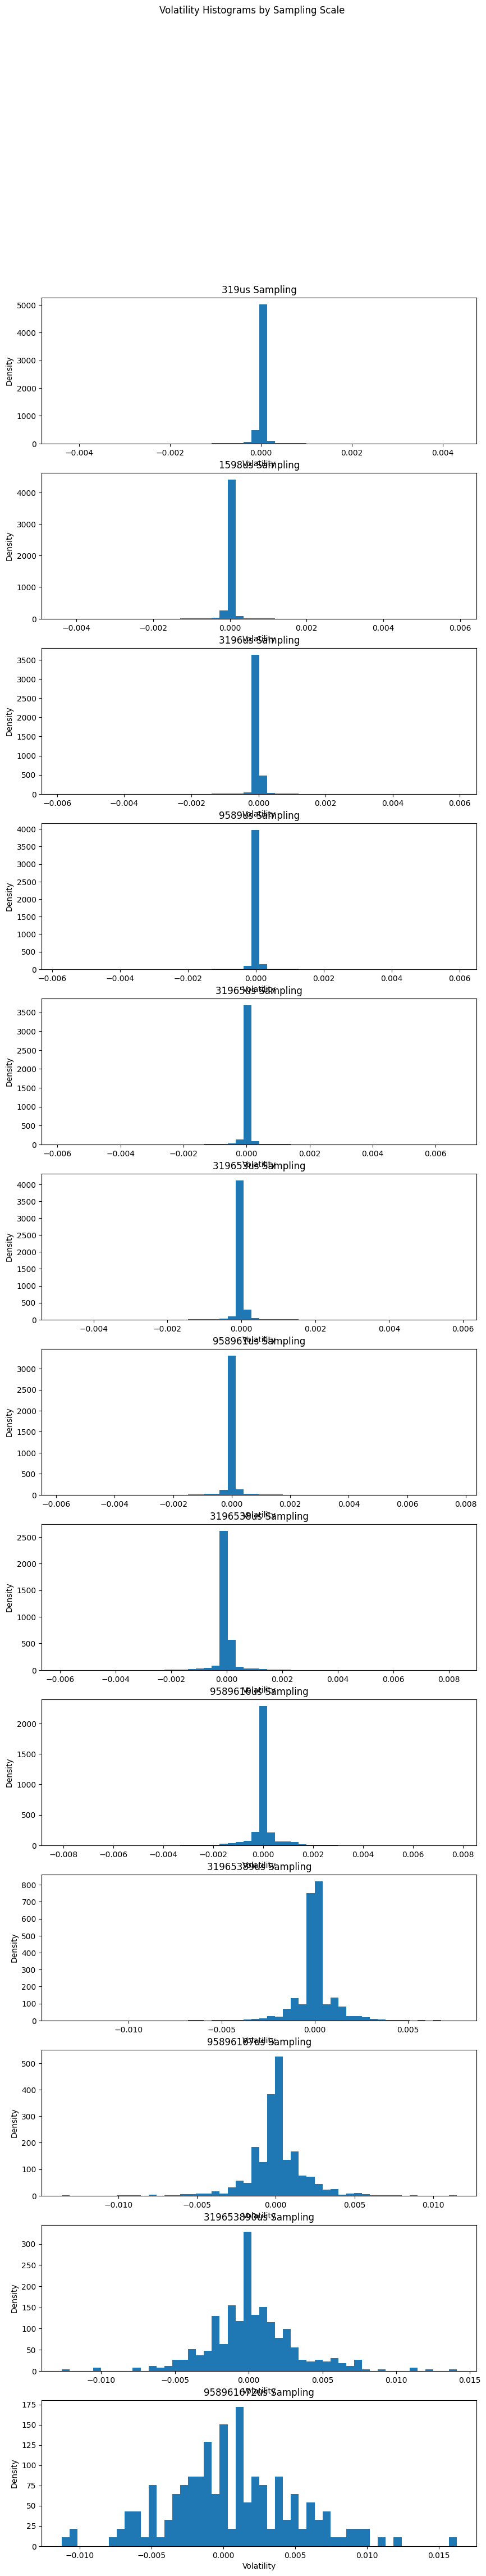

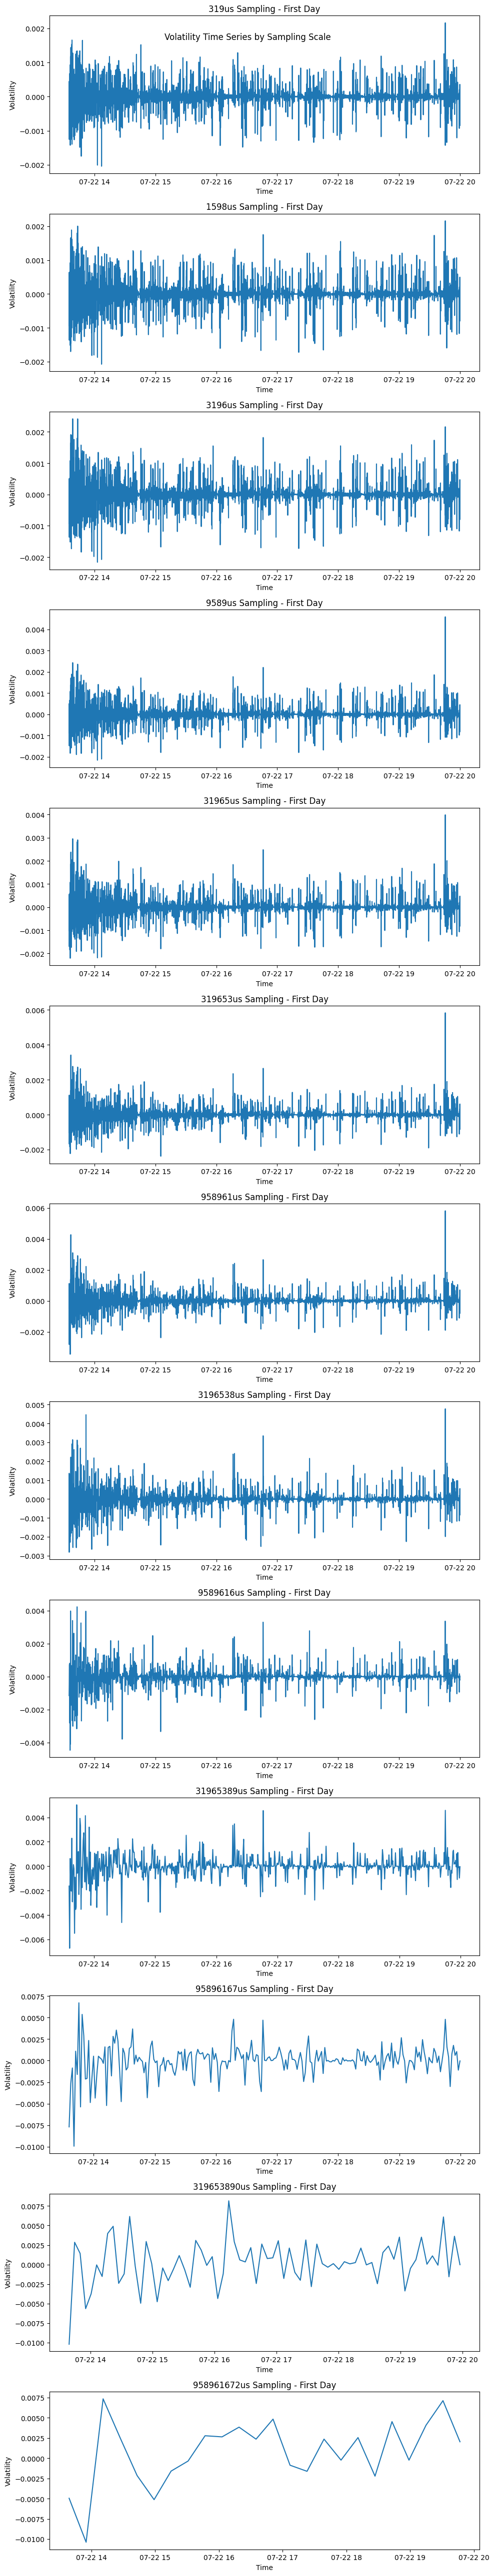

In [21]:
# Plot histograms and time series of volatility for each sampling scale
import matplotlib.pyplot as plt

# Create subplots for histograms
fig_hist, axes_hist = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_hist.suptitle('Volatility Histograms by Sampling Scale')

# Create subplots for time series
fig_ts, axes_ts = plt.subplots(len(time_scales), 1, figsize=(10, 4*len(time_scales)))
fig_ts.suptitle('Volatility Time Series by Sampling Scale')

for i, scale in enumerate(time_scales):
    df_current = dfs[scale]
    
    # Plot histogram
    vol_data = df_current.select('log_variation').to_numpy().flatten()
    axes_hist[i].hist(vol_data[~np.isnan(vol_data)], bins=50, density=True)  # Remove NaN values
    axes_hist[i].set_title(f'{scale} Sampling')
    axes_hist[i].set_xlabel('Volatility')
    axes_hist[i].set_ylabel('Density')
    
    # Plot time series - first day only
    first_day = df_current.select('ts_event').to_numpy()[0].astype('datetime64[D]')
    mask = df_current.select('ts_event').to_numpy().astype('datetime64[D]') == first_day
    
    axes_ts[i].plot(df_current.select('ts_event').to_numpy()[mask], 
                    df_current.select('log_variation').to_numpy()[mask])
    axes_ts[i].set_title(f'{scale} Sampling - First Day')
    axes_ts[i].set_xlabel('Time') 
    axes_ts[i].set_ylabel('Volatility')

plt.tight_layout()
plt.show()
plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_volatility_histograms_{threshold}.png")
plt.close("all")

In [23]:
for scale in time_scales:
    # describe all columns
    print(dfs[scale].describe())

shape: (9, 7)
┌────────────┬──────────────┬───────────┬──────────────┬──────────────┬──────────────┬─────────────┐
│ statistic  ┆ ts_event     ┆ mid_price ┆ tick_variati ┆ log_variatio ┆ dt           ┆ vol_bacheli │
│ ---        ┆ ---          ┆ ---       ┆ on           ┆ n            ┆ ---          ┆ er          │
│ str        ┆ str          ┆ f64       ┆ ---          ┆ ---          ┆ f64          ┆ ---         │
│            ┆              ┆           ┆ f64          ┆ f64          ┆              ┆ f64         │
╞════════════╪══════════════╪═══════════╪══════════════╪══════════════╪══════════════╪═════════════╡
│ count      ┆ 408478       ┆ 408478.0  ┆ 408471.0     ┆ 408471.0     ┆ 408477.0     ┆ 408471.0    │
│ null_count ┆ 0            ┆ 0.0       ┆ 7.0          ┆ 7.0          ┆ 1.0          ┆ 7.0         │
│ mean       ┆ 2024-07-26   ┆ 8.401067  ┆ 0.000144     ┆ 1.8689e-7    ┆ 1.748691     ┆ 0.083528    │
│            ┆ 03:19:27.928 ┆           ┆              ┆              ┆      

In [33]:
time_scales = time_scales[::-1]

Calculating autocorrelation for each scale:   0%|          | 0/13 [00:00<?, ?it/s]

958961672us


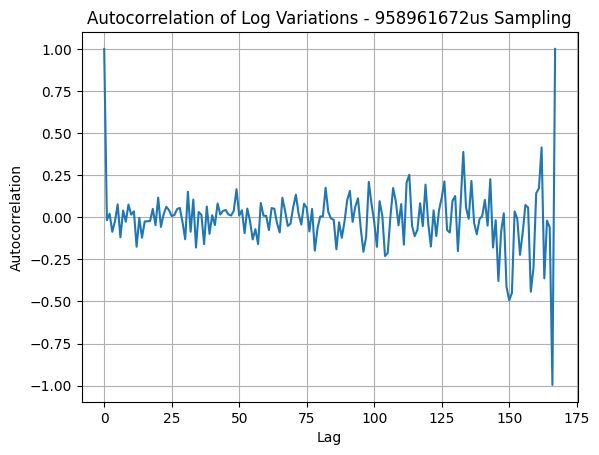

Calculating autocorrelation for each scale:   8%|▊         | 1/13 [00:00<00:01,  8.65it/s]

319653890us


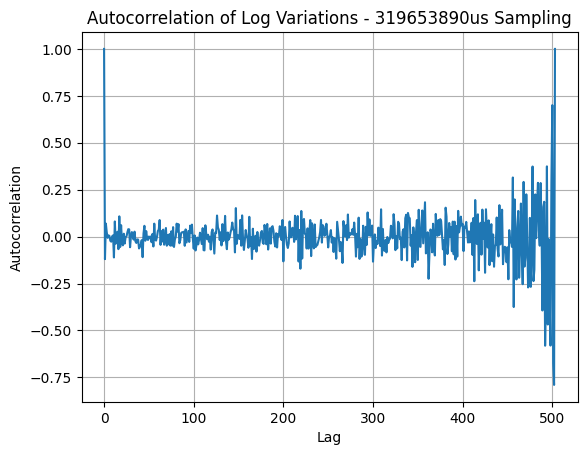

Calculating autocorrelation for each scale:  15%|█▌        | 2/13 [00:00<00:01,  9.38it/s]

95896167us


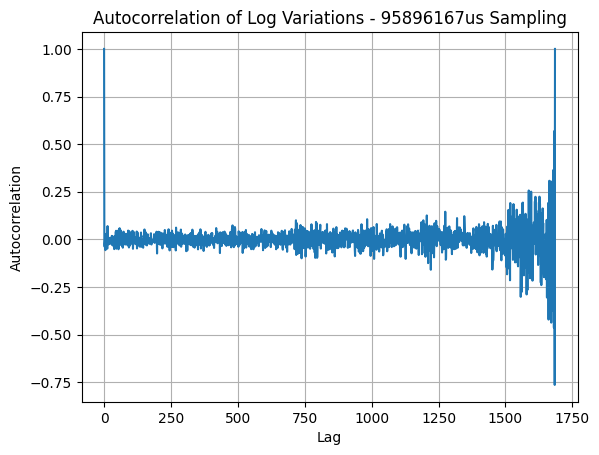

Calculating autocorrelation for each scale:  23%|██▎       | 3/13 [00:00<00:01,  8.00it/s]

31965389us


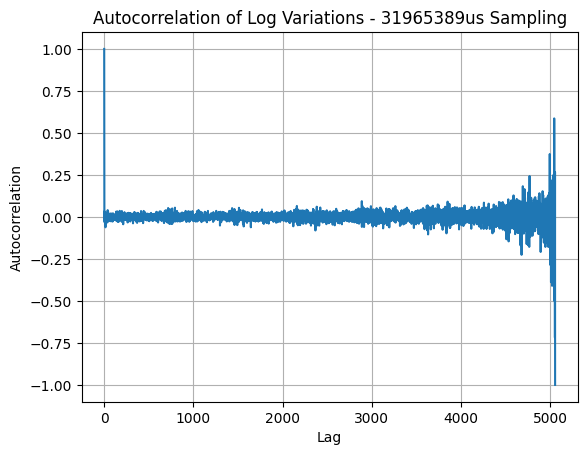

Calculating autocorrelation for each scale:  31%|███       | 4/13 [00:00<00:01,  5.21it/s]

9589616us


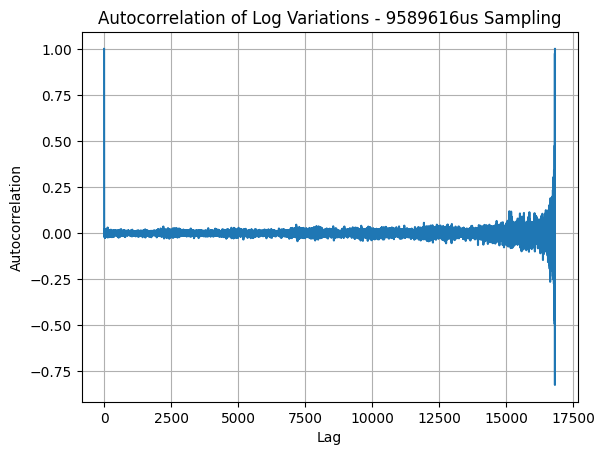

Calculating autocorrelation for each scale:  38%|███▊      | 5/13 [00:01<00:03,  2.05it/s]

3196538us


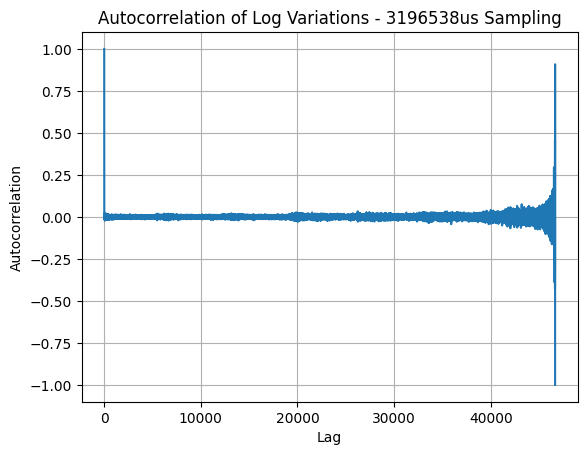

Calculating autocorrelation for each scale:  46%|████▌     | 6/13 [00:06<00:13,  1.97s/it]

958961us


Calculating autocorrelation for each scale:  46%|████▌     | 6/13 [00:07<00:08,  1.26s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [37]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags, autocorr)
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}log_var_vanilla.png")


Calculating autocorrelation for each scale:   0%|          | 0/13 [00:00<?, ?it/s]

958961672us


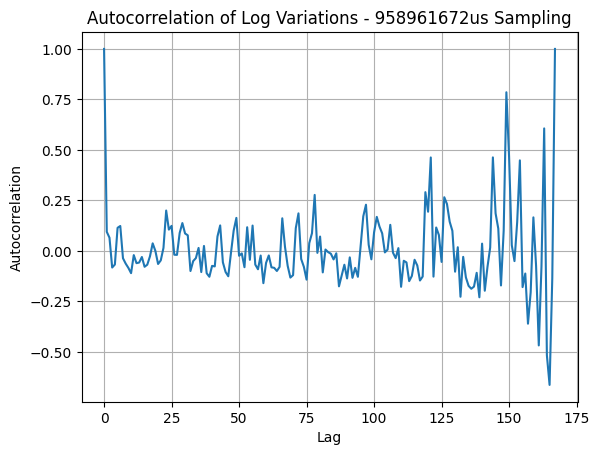

319653890us


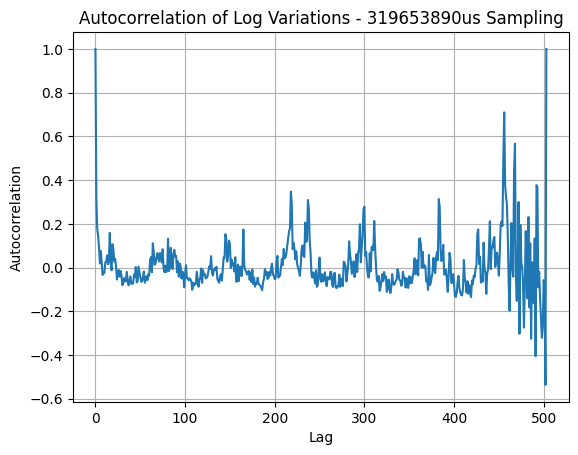

Calculating autocorrelation for each scale:  15%|█▌        | 2/13 [00:00<00:00, 11.51it/s]

95896167us


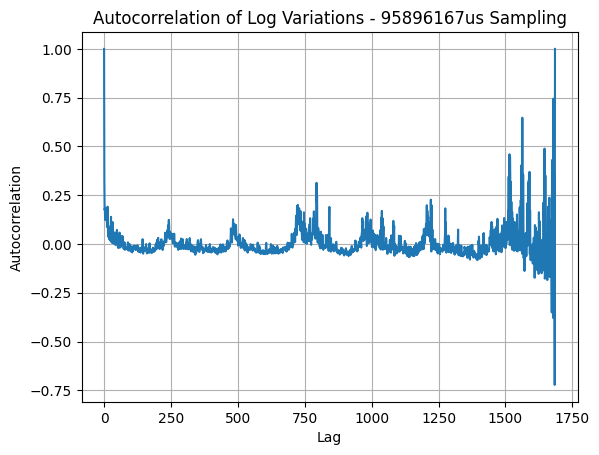

31965389us


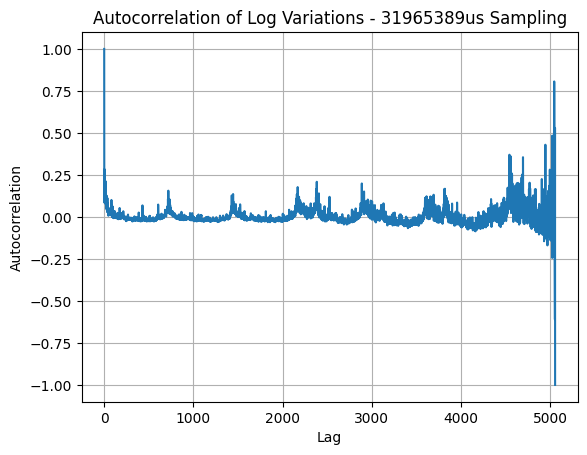

Calculating autocorrelation for each scale:  31%|███       | 4/13 [00:00<00:01,  6.33it/s]

9589616us


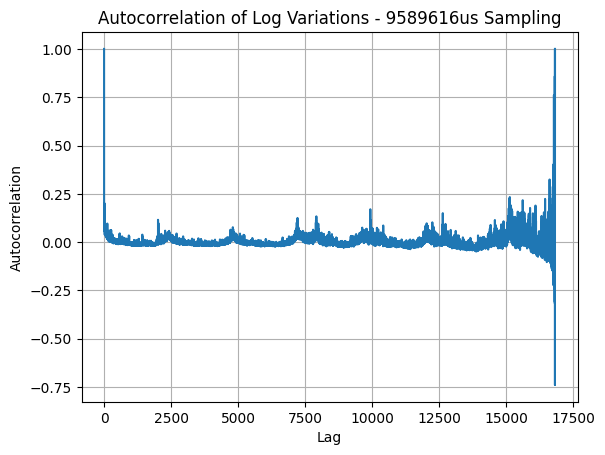

Calculating autocorrelation for each scale:  38%|███▊      | 5/13 [00:01<00:03,  2.54it/s]

3196538us


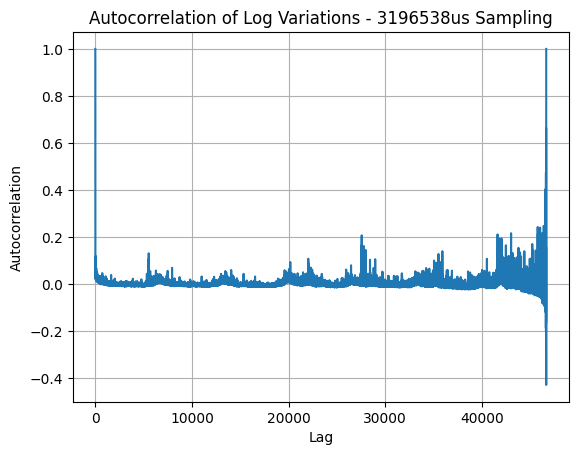

Calculating autocorrelation for each scale:  46%|████▌     | 6/13 [00:06<00:11,  1.71s/it]

958961us


Calculating autocorrelation for each scale:  46%|████▌     | 6/13 [00:19<00:22,  3.21s/it]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [38]:
#plot autocorrelation of log variations

for scale in tqdm(time_scales[::-1], "Calculating autocorrelation for each scale"):
    # to npy and remove nans
    print(scale)
    log_var = dfs[scale].select("log_variation").to_numpy().flatten()
    log_var = log_var[~np.isnan(log_var)]
    log_var = log_var * log_var
    n = len(log_var)
    lags = np.arange(n)
    autocorr = np.array([np.corrcoef(log_var[:-lag], log_var[lag:])[0,1] if lag > 0 else 1 for lag in lags])

    plt.plot(lags, autocorr)
    plt.title(f"Autocorrelation of Log Variations - {scale} Sampling")
    plt.xlabel("Lag")
    plt.grid()
    plt.ylabel("Autocorrelation")
    plt.show()
    plt.savefig(f"/home/janis/HFTP2/HFT/results/hurst/plots/{stock}/{stock}_autocorrelation_{scale}_squared_logvar.png")
